In [167]:
%%capture
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
import spacy
import ast
import re
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tqdm
import gdown
from functools import partial
import pickle
import time
import datetime
import os
import sys
import gdown
import glob

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bertscore_score

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


In [ ]:
if torch.backends.mps.is_available():
    DEVICE = 'mps'  
elif torch.cuda.is_available():
    DEVICE = 'cuda' 
else:
    DEVICE = 'cpu'   

print(DEVICE)

cuda


In [169]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load dataset

In [ ]:

train_path = 'Cooking_Dataset/train.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'


if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset") 
    gdown.download("https://drive.google.com/uc?id=1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU", train_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF", dev_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr", test_path, quiet=False)


train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)



# Check dataset
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
#print("\nTrain data sample:")
#print(train_df.head())


Train data size: 162899
Dev data size: 1065
Test data size: 1081


# Tokenization

In [171]:
spacy_en = spacy.load("en_core_web_sm")

def tokenizer_ingredients_baseline(text):
    """
    Baseline preprocessing: lowercasing + lemmatization + simple filtering
    - Stopword removal included
    - Numbers and punctuation are removed
    - No complex preprocessing is applied
    """
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_space or token.is_punct or token.like_num or token.is_stop:
                    continue
                lemma = token.lemma_.strip()
                if lemma:
                    tokens.append(lemma)
    return tokens



def tokenizer_ingredients_extension(
    text: str,
    remove_stopwords: bool = False
) -> list[str]:
    """
    - Removes quantity + up to 3 modifiers + unit as a whole
    - Removes parentheses, content after commas, and special characters
    - Filters out unnecessary POS tags and unit-related keywords
    - Ignores tokens that appear after CCONJ or PART
    """

    unit_keywords = {
        "x","sm","md","lg","cn","pk","pn","dr","ds","ct",
        "bn","sl","ea","t","ts","tb","fl","c","pt","qt","ga",
        "oz","lb","ml","cb","cl","dl","l","mg","cg","dg","g","kg",
        "cup","tbsp","tablespoon","tsp","teaspoon","ounce","pound",
        "carton","container","package","pkg","envelope","box","bag","jar","bottle",
        "dash","pinch","slice","head","inch","half","whole","chop",
        "stick","small","medium","large","size","graham","regular"
    }

    try:
        items = ast.literal_eval(text)
    except Exception:
        return []

    flat_results: list[str] = []
    with spacy_en.select_pipes(disable=["ner"]):
        for item in items:
            s = item.lower().strip()
            s = re.sub(r'^\s*(\d+(/\d+)?(\s+\w+){0,3}?\s+\w+\.)\s*', '', s)
            s = re.sub(r'\([^)]*\)', '', s)
            s = re.sub(r',.*', '', s)
            s = re.sub(r'[,;^*\.\&:<>\(\)\[\]~=\+]', '', s)

            doc = spacy_en(s)
            tokens = []
            for token in doc:
                if token.pos_ in {"CCONJ", "PART"}:
                    break
                
                word = token.text.strip()
                if (
                    not any(c.isalpha() for c in word)
                    or token.is_space
                    or token.is_punct
                    or word in unit_keywords
                    or token.pos_ in {"NUM", "VERB", "ADP", "ADJ"}
                    or (remove_stopwords and token.is_stop)
                ):
                    continue
                tokens.append(word)

            if tokens:
                flat_results.extend(tokens)

    return flat_results

def tokenizer_recipe(text):
    """
    - Lowercasing
    - Removes special characters 
    - Simple whitespace-based tokenization
    - No lemmatization
    - Keeps numbers and stopwords
    """

    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner", "lemmatizer", "tagger"]):
        for item in text_list:
            item = item.lower().strip()

            # Removes special characters
            item = re.sub(r'[,;^*\.\&:<>\(\)\[\]~=\+!?\"\'`]', '', item)

            # Tokenization based on whitespace
            doc = spacy_en(item)
            for token in doc:
                word = token.text.strip()
                if word and not token.is_space:
                    tokens.append(word)

    return tokens


def tokenizer_test(text):
    doc = spacy_en(text)  # No preprocessing, just tokenization
    return [token.text for token in doc]



In [172]:
def build_vocab(token_lists, min_freq=2):
    # vocab creation: only frequent words + special tokens
    vocab = build_vocab_from_iterator(
        token_lists,  # token lists
        min_freq=min_freq,  # minimum frequency
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # special tokens
    )
    vocab.set_default_index(vocab['<unk>'])  # unknown tokens
    return vocab

In [173]:
class CustomDataset(Dataset):
    def __init__(
        self, df,
        ingredient_tokenizer, recipe_tokenizer,
        ingredient_vocab, recipe_vocab,
        test_tokenizer=None, augment_ratio=None, expand_size=False
    ):
        self.df = df
        self.ingredient_tokenizer = ingredient_tokenizer
        self.recipe_tokenizer = recipe_tokenizer
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab
        self.test_tokenizer = test_tokenizer
        self.augment_ratio = augment_ratio
        self.expand_size = expand_size

    def __len__(self):
        return len(self.df) * 2 if self.expand_size else len(self.df)

    def __getitem__(self, idx):
        if self.expand_size:
            orig_idx = idx // 2
            use_test_tokenizer = (idx % 2 == 1) and (self.test_tokenizer is not None)
        else:
            orig_idx = idx
            use_test_tokenizer = (
                self.augment_ratio is not None and 
                random.random() < self.augment_ratio and 
                self.test_tokenizer is not None
            )

        ing_text = self.df.iloc[orig_idx]['Ingredients']
        rec_text = self.df.iloc[orig_idx]['Recipe']

        if use_test_tokenizer:
            ing_tokens = self.test_tokenizer(ing_text)
            rec_tokens = self.test_tokenizer(rec_text)
        else:
            ing_tokens = self.ingredient_tokenizer(ing_text)
            rec_tokens = self.recipe_tokenizer(rec_text)

        ing_ids = self.ingredient_vocab.lookup_indices(ing_tokens)
        rec_input_ids  = [self.recipe_vocab["<sos>"]] + self.recipe_vocab.lookup_indices(rec_tokens)
        rec_target_ids = self.recipe_vocab.lookup_indices(rec_tokens) + [self.recipe_vocab["<eos>"]]

        return (
            torch.tensor(ing_ids, dtype=torch.long),
            torch.tensor(rec_input_ids, dtype=torch.long),
            torch.tensor(rec_target_ids, dtype=torch.long),
            rec_text,
            ing_text
        )


In [174]:
def collate_fn(batch, ingredient_vocab, recipe_vocab, device):
    """
    batch: list of tuples from CustomDataset
    ingredient_pad_idx, recipe_pad_idx: vocab['<pad>']
    """
    # Unpacking
    ing_ids, rec_inputs, rec_targets, rec_texts, ing_texts = zip(*batch)

    # Padding
    ing_ids   = pad_sequence(ing_ids,   batch_first=True, padding_value=ingredient_vocab['<pad>'])
    rec_inputs  = pad_sequence(rec_inputs,  batch_first=True, padding_value=recipe_vocab['<pad>'])
    rec_targets = pad_sequence(rec_targets, batch_first=True, padding_value=recipe_vocab['<pad>'])

    # Device
    ing_ids      = ing_ids.to(device)
    rec_inputs   = rec_inputs.to(device)
    rec_targets  = rec_targets.to(device)

    return ing_ids, rec_inputs, rec_targets, rec_texts, ing_texts    

# Encoder-Decoder,Seq2Seq Model

In [ ]:
class Encoder_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, dropout=0.5, embedding_weights=None, freeze_embedding=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # dropout
        self.dropout = nn.Dropout(dropout)
        # GRU layer
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
    def forward(self, src):
        # src: [batch_size, src_len]
        src = src.long()

        # embedded: [batch_size, src_len, embedding_dim]
        embedded = self.dropout(self.embedding(src))

        # outputs: [batch_size, src_len, hidden_dim]
        # hidden: [n_layers, batch_size, hidden_dim]
        outputs, hidden = self.gru(embedded)

        return outputs, hidden

class Encoder_GRU_extension(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, dropout=0.5, 
                 embedding_weights=None, freeze_embedding=True):
        super().__init__()
        
        # Use GloVe embedding (if pre-trained embedding is available)
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_weights, freeze=freeze_embedding, padding_idx=0
            )
            # Add linear adapter for GloVe embedding
            self.embedding_adapter = nn.Linear(embedding_dim, embedding_dim)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            self.embedding_adapter = nn.Identity()  # No embedding when no pre-trained embedding
        
        # Other layers and functions
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        
        # Token importance attention layer
        self.token_attention = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        self.attention_scale = nn.Parameter(torch.tensor(0.5))
        self.layer_norm = nn.LayerNorm(embedding_dim)
        
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                if param.dim() > 1:
                    # Apply Xavier initialization to linear layers and GRU weights
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                # Initialize all biases to 0
                nn.init.constant_(param, 0)
    
    def forward(self, src):
        src = src.long()
        
        # GloVe embedding + adapter
        base_embedded = self.embedding(src)
        adapted_embedded = self.embedding_adapter(base_embedded)
        
        # Token importance calculation
        attention_scores = self.token_attention(adapted_embedded).squeeze(-1)
        mask = (src != 0).float()
        attention_scores = attention_scores.masked_fill(src == 0, -1e9)
        attention_weights = F.softmax(attention_scores, dim=1) * mask
        
        # Apply scaled weights
        scaling_factor = 1.0 + (attention_weights * self.attention_scale)
        weighted_embedded = adapted_embedded * scaling_factor.unsqueeze(-1)
        
        # Normalization and dropout
        normalized_embedded = self.layer_norm(weighted_embedded)
        embedded = self.dropout(normalized_embedded)
        
        # GRU pass
        outputs, hidden = self.gru(embedded)
        
        return outputs, hidden, attention_weights



class Decoder_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, dropout=0.5, embedding_weights=None, freeze_embedding=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Dropout
        self.dropout = nn.Dropout(dropout)
        # GRU
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        # Linear layer: hidden_dim → vocab_size
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, hidden):
        input = input.long()
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, num of words=1]

        # Embedding
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, num of words=1, hidden_dim]

        # GRU pass
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, num of words=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc pass
        logits = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return logits, hidden


class AttnDecoder_GRU(nn.Module):
    def __init__(self, vocab_size,embedding_dim, hidden_dim, n_layers=1, dropout=0.5, embedding_weights=None, freeze_embedding=False, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.dropout = nn.Dropout(dropout)

        # GRU (input: embedding only)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        self.out = nn.Linear(hidden_dim * 2, vocab_size)


    def forward(self, input, hidden, encoder_outputs):
   
        input = input.long() 
        # [B] → [B, 1]
        input = input.unsqueeze(1)
        # Embedding + Dropout
        embedded = self.dropout(self.embedding(input))  # [B, 1, E]

        # GRU
        output, hidden = self.gru(embedded, hidden)  # output: [B, 1, H]

        # Dot-Product Attention
        # output: [B, 1, H] → [B, H, 1]
        attn_scores = torch.bmm(encoder_outputs, output.transpose(1, 2))  # [B, src_len, 1]
        attn_weights = F.softmax(attn_scores.squeeze(2), dim=1)          # [B, src_len]

        # Weighted sum of encoder_outputs (context vector)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [B, 1, H]

        # Concatenate GRU output + context → vocab prediction
        concat = torch.cat((output, context), dim=2)         # [B, 1, 2H]
        output_logits = self.out(concat.squeeze(1))          # [B, vocab_size]

        return output_logits, hidden, attn_weights

class AttnDecoder_GRU_extension(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, dropout=0.5, 
                 embedding_weights=None, freeze_embedding=False, use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        
        # Use GloVe embedding (if pre-trained embedding is available)
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_weights, freeze=freeze_embedding, padding_idx=0
            )
            # Add linear adapter for GloVe embedding
            self.embedding_adapter = nn.Linear(embedding_dim, embedding_dim)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            self.embedding_adapter = nn.Identity()  # No embedding when no pre-trained embedding

        self.dropout = nn.Dropout(dropout)

        # GRU
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Enhanced attention mechanism
        self.context_attn = nn.Linear(hidden_dim, hidden_dim)
        
        # Enhanced output layer
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, vocab_size)
        )
        
        # Word importance memory (trained within a restricted range)
        # Initialize to 0 so that all values start at 0.5 when sigmoid is applied
        self.word_importance = nn.Parameter(torch.zeros(vocab_size))
        
        self.init_weights()

    def init_weights(self):
      
        for name, param in self.named_parameters():
            if 'weight' in name and 'embedding' not in name:
                if param.dim() > 1:
                   
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
              
                nn.init.constant_(param, 0)

    def forward(self, input, hidden, encoder_outputs):
     
        input = input.long() 
        # [B] → [B, 1]
        input = input.unsqueeze(1)
        
        # Embedding + adapter + Dropout
        base_embedded = self.embedding(input)
        adapted_embedded = self.embedding_adapter(base_embedded)
        embedded = self.dropout(adapted_embedded)

        # GRU
        output, hidden = self.gru(embedded, hidden)  # output: [B, 1, H]

        # Enhanced attention mechanism
        transformed_output = self.context_attn(output)  # [B, 1, H]
        
        # Attention score calculation
        attn_scores = torch.bmm(
            transformed_output, encoder_outputs.transpose(1, 2)
        )  # [B, 1, src_len]
        
        attn_weights = F.softmax(attn_scores.squeeze(1), dim=1)  # [B, src_len]

        # Context vector calculation
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # [B, 1, H]

        # Concatenate GRU output + context
        concat = torch.cat((output, context), dim=2)  # [B, 1, 2H]
        
        # Enhanced output calculation
        output_vector = concat.squeeze(1)  # [B, 2H]
        logits = self.output_proj(output_vector)  # [B, vocab_size]
        
        # Word importance weight application (restricted to 0.5~1.5 range via sigmoid)
        # If importance > 1, increase probability of that word; if < 1, decrease it
        importance_weights = 0.5 + torch.sigmoid(self.word_importance)
        logits = logits * importance_weights
        
        return logits, hidden, attn_weights
    
    def importance_regularization_loss(self, lambda_reg=0.01):
        # Apply L2 regularization to prevent importance values from becoming too extreme
        return lambda_reg * (self.word_importance ** 2).mean()



class DecoderWithCopyChecklist(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers=1, dropout=0.5,
                 embedding_weights=None, freeze_embedding=False,
                 checklist_vocab=None, checklist_tokenizer=None, copy_vocab=None,copy_tokenizer=None,
                 use_checklist=False, use_copy=False):
        super().__init__()
        self.device =DEVICE

        self.use_checklist = use_checklist
        self.use_copy = use_copy
        self.checklist_vocab = checklist_vocab
        self.checklist_tokenizer = checklist_tokenizer
        self.copy_vocab = copy_vocab
        self.copy_tokenizer = copy_tokenizer

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embedding, padding_idx=0) if embedding_weights is not None else nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout if n_layers > 1 else 0, batch_first=True)

        # Attention and projection
        self.attn_proj = nn.Linear(hidden_dim, hidden_dim)
        self.skip_proj = nn.Linear(embedding_dim, hidden_dim * 2)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.context_out = nn.Linear(hidden_dim * 2, vocab_size)

        # Copy mechanism
        self.p_gen_linear = nn.Linear(hidden_dim * 2 + embedding_dim, 1)

        # Checklist
        self.checklist_embedding = nn.Embedding(len(checklist_vocab), embedding_dim, padding_idx=0)
        self.checklist_proj = nn.Linear(hidden_dim, embedding_dim)
        self.ref_type_classifier = nn.Linear(hidden_dim, 3)
        self.h_proj = nn.Linear(embedding_dim, hidden_dim)
        self.c_proj = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def build_token_inputs(self, texts, vocab, tokenizer, embedding_layer=None):
 
        token_lists = [tokenizer(text) for text in texts]
        max_len = max(len(toks) for toks in token_lists)
        B = len(token_lists)

        token_ids = torch.full((B, max_len), vocab['<pad>'], dtype=torch.long)
        token_mask = torch.zeros((B, max_len), dtype=torch.bool)

        for i, toks in enumerate(token_lists):
            for j, tok in enumerate(toks):
                if tok in vocab:
                    token_ids[i][j] = vocab[tok]
                    token_mask[i][j] = True

        token_ids = token_ids.to(self.device)
        token_mask = token_mask.to(self.device)

        if embedding_layer is not None:
            token_embeds = embedding_layer(token_ids)
            return token_ids, token_mask, token_embeds
        else:
            return token_ids, token_mask


    def forward(self, input_token, hidden, encoder_outputs, encoder_input_ids=None, ing_texts=None, a_prev=None):
        B, src_len, H = encoder_outputs.size()
        device = encoder_outputs.device  

        embedded = self.dropout(self.embedding(input_token.long())).unsqueeze(1)
        output, hidden = self.gru(embedded, hidden)
        out_flat = output.squeeze(1)

        attn_scores = torch.bmm(encoder_outputs, output.transpose(1, 2)).squeeze(2)
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        concat = torch.cat([output, context.unsqueeze(1)], dim=2)
        skip = self.skip_proj(embedded)
        combined = self.layer_norm(concat + skip).squeeze(1)
        vocab_logits = self.context_out(combined)
        log_probs = F.log_softmax(vocab_logits, dim=1)

        logits_from_checklist = None
        alpha_new = None
        p_gen = None

        # COPY MECHANISM 
        if self.use_copy and encoder_input_ids is not None:
            copy_ids = encoder_input_ids  # [B, src_len]
            one_hot = F.one_hot(copy_ids, num_classes=self.vocab_size).float()

  # [B, src_len, V]

            P_vocab = F.softmax(vocab_logits, dim=1)
            P_copy = torch.bmm(attn_weights.unsqueeze(1), one_hot).squeeze(1)  # [B, V]

            p_gen_input = torch.cat([context, out_flat, embedded.squeeze(1)], dim=1)
            p_gen = torch.sigmoid(self.p_gen_linear(p_gen_input))
            P_final = p_gen * P_vocab + (1 - p_gen) * P_copy
            log_probs = torch.log(P_final + 1e-12)


       
        # CHECKLIST MECHANISM 
        if self.use_checklist and ing_texts is not None and a_prev is not None:
            checklist_ids, checklist_mask, checklist_embeds = self.build_token_inputs(
                texts=ing_texts,
                vocab=self.checklist_vocab,
                tokenizer=self.checklist_tokenizer,
                embedding_layer=self.checklist_embedding
            )

            ref_logits = self.ref_type_classifier(out_flat)
            ref_probs = F.softmax(ref_logits, dim=1)
            f_gru, f_new, f_used = ref_probs[:, 0], ref_probs[:, 1], ref_probs[:, 2]

            q = self.checklist_proj(out_flat).unsqueeze(2)  # [B, E, 1]

            attn_new = torch.bmm(checklist_embeds, q).squeeze(2)
            attn_new = attn_new.masked_fill(checklist_mask, -1e9)
            alpha_new = F.softmax(attn_new, dim=1)
            c_new = torch.bmm(alpha_new.unsqueeze(1), checklist_embeds).squeeze(1)

            attn_used = torch.bmm(checklist_embeds, q).squeeze(2)
            attn_used = attn_used.masked_fill(~checklist_mask, -1e9)
            alpha_used = F.softmax(attn_used, dim=1)
            c_used = torch.bmm(alpha_used.unsqueeze(1), checklist_embeds).squeeze(1)

            c_new = self.h_proj(c_new)
            c_used = self.h_proj(c_used)

            o_t = f_gru.unsqueeze(1) * out_flat + f_new.unsqueeze(1) * c_new + f_used.unsqueeze(1) * c_used
            logits_from_checklist = self.c_proj(o_t)

           
            if a_prev.size(1) != alpha_new.size(1):
                if a_prev.size(1) < alpha_new.size(1):
                    pad_len = alpha_new.size(1) - a_prev.size(1)
                    a_prev = F.pad(a_prev, (0, pad_len)) 
                else:
                    a_prev = a_prev[:, :alpha_new.size(1)]  

            a_next = a_prev + alpha_new
        else:
            a_next = a_prev


        return log_probs, hidden, a_next, attn_weights, p_gen, alpha_new, logits_from_checklist



def build_checklist_target(checklist_ids, checklist_mask, vocab_size):
    B, N = checklist_ids.shape
    target = torch.zeros(B, vocab_size, device=checklist_ids.device)
    checklist_mask = checklist_mask.float()
    target.scatter_(1, checklist_ids, checklist_mask)
    return target





class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, recipe_vocab):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.recipe_vocab = recipe_vocab
        self.pad_idx = recipe_vocab['<pad>'] if '<pad>' in recipe_vocab else 0
        self.sos_idx = recipe_vocab['<sos>'] if '<sos>' in recipe_vocab else 1
        self.eos_idx = recipe_vocab['<eos>'] if '<eos>' in recipe_vocab else 2
        self.vocab_size = len(recipe_vocab)

        self.use_checklist = getattr(self.decoder, 'use_checklist', False)
        self.use_copy = getattr(self.decoder, 'use_copy', False)
        self.use_attention = getattr(self.decoder, 'use_attention', False)

    def forward(self, src, target=None, ing_texts=None, encoder_input_ids=None,
            teacher_forcing_ratio=0.5, max_len=50):

        encoder_outputs, hidden = self.encoder(src)[:2]
        batch_size = src.size(0)

        if hidden.size(0) > self.decoder.gru.num_layers:
            hidden = hidden[-self.decoder.gru.num_layers:]
        elif hidden.size(0) < self.decoder.gru.num_layers:
            hidden = hidden.repeat(self.decoder.gru.num_layers, 1, 1)

        # checklist attention 
        a_prev = None
        if self.use_checklist and ing_texts is not None:
            max_chk_len = max(len(self.decoder.checklist_tokenizer(text)) for text in ing_texts)
            a_prev = torch.zeros(batch_size, max_chk_len, device=self.device)

        # Input token
        target_len = target.size(1) if target is not None else max_len
        input_token = target[:, 0] if target is not None else torch.full((batch_size,), self.sos_idx, dtype=torch.long, device=self.device)

        # output
        outputs = torch.zeros(batch_size, target_len, self.vocab_size).to(self.device)
        attn_weights_list, p_gens, alpha_news, checklist_logits = [], [], [], []

        for t in range(1, target_len):
    
            if self.use_checklist or self.use_copy:
                log_probs, hidden, a_prev, attn_weights, p_gen, alpha_new, checklist_logit = self.decoder(
                    input_token=input_token,
                    hidden=hidden,
                    encoder_outputs=encoder_outputs,
                    ing_texts=ing_texts if self.use_checklist else None,
                    encoder_input_ids=encoder_input_ids if self.use_copy else None,
                    a_prev=a_prev
                )
            elif self.use_attention:
                log_probs, hidden, attn_weights = self.decoder(input_token, hidden, encoder_outputs)
                p_gen, alpha_new, checklist_logit = None, None, None
            else:
                log_probs, hidden = self.decoder(input_token, hidden)
                attn_weights, p_gen, alpha_new, checklist_logit = None, None, None, None

            outputs[:, t, :] = log_probs
            attn_weights_list.append(attn_weights)
            p_gens.append(p_gen)
            alpha_news.append(alpha_new)
            checklist_logits.append(checklist_logit)

            # teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = log_probs.argmax(1)
            input_token = target[:, t] if teacher_force and target is not None else top1

        reg_loss = self.decoder.importance_regularization_loss() if hasattr(self.decoder, 'importance_regularization_loss') else 0.0

        return outputs, attn_weights_list, p_gens, alpha_news, checklist_logits, None, reg_loss


    def beam_search(self, src, encoder_outputs, hidden, ing_texts=None, encoder_input_ids=None, max_len=50, beam_size=5, a_prev=None):
        batch_size = src.size(0)
        device = src.device
        all_sequences = []

        for b in range(batch_size):
            enc_out = encoder_outputs[b:b+1]
            hid = hidden[:, b:b+1, :]
            ing_text = [ing_texts[b]] if (self.use_checklist and ing_texts is not None) else None
            src_ids = encoder_input_ids[b:b+1] if (self.use_copy and encoder_input_ids is not None) else None
            a_prev_b = a_prev[b:b+1] if (self.use_checklist and a_prev is not None) else None

            beams = [(0.0, [self.sos_idx], hid, a_prev_b)]

            for _ in range(max_len - 1):
                new_beams = []
                for score, seq, hid_, a_prev_ in beams:
                    last_token = seq[-1]
                    if last_token == self.eos_idx:
                        new_beams.append((score, seq, hid_, a_prev_))
                        continue

                    input_token = torch.tensor([last_token], device=device)

                    if self.use_checklist or self.use_copy:
                        decoder_out = self.decoder(
                            input_token=input_token,
                            hidden=hid_,
                            encoder_outputs=enc_out,
                            ing_texts=ing_text,
                            encoder_input_ids=src_ids,
                            a_prev=a_prev_
                        )
                        log_probs, new_hid, new_a_prev = decoder_out[:3]
                    elif self.use_attention:
                        log_probs, new_hid, _ = self.decoder(input_token, hid_, enc_out)
                        new_a_prev = a_prev_
                    else:
                        log_probs, new_hid = self.decoder(input_token, hid_)
                        new_a_prev = a_prev_

                    topk_log_probs, topk_indices = log_probs.topk(beam_size)
                    for i in range(beam_size):
                        tok = topk_indices[0, i].item()
                        tok_logp = topk_log_probs[0, i].item()
                        new_seq = seq + [tok]
                        new_score = score + tok_logp
                        new_beams.append((new_score, new_seq, new_hid, new_a_prev))

                beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
                if all(seq[-1] == self.eos_idx for _, seq, _, _ in beams):
                    break

            best_seq = beams[0][1]
            if self.eos_idx in best_seq:
                eos_pos = best_seq.index(self.eos_idx)
                best_seq = best_seq[:eos_pos+1] + [self.pad_idx] * (max_len - eos_pos - 1)
            else:
                best_seq = best_seq + [self.pad_idx] * (max_len - len(best_seq))

            all_sequences.append(best_seq[:max_len])

        return torch.tensor(all_sequences, device=device)



    def generate(self, src, ing_texts=None, encoder_input_ids=None, max_len=50, beam_size=None):
        self.eval()
        with torch.no_grad():
            encoder_outputs, hidden = self.encoder(src)[:2]

 
            if hidden.size(0) > self.decoder.gru.num_layers:
                hidden = hidden[-self.decoder.gru.num_layers:]
            elif hidden.size(0) < self.decoder.gru.num_layers:
                hidden = hidden.repeat(self.decoder.gru.num_layers, 1, 1)

            batch_size = src.size(0)

            # Initial a_prev for checklist
            a_prev = None
            if self.use_checklist:
                if ing_texts is None or self.decoder.checklist_tokenizer is None:
                    raise ValueError("Checklist is enabled, but ing_texts or tokenizer is missing.")
                max_len_chk = max(len(self.decoder.checklist_tokenizer(text)) for text in ing_texts)
                a_prev = torch.zeros(batch_size, max_len_chk, device=self.device)

            # Beam Search
            if beam_size and beam_size > 1:
                return self.beam_search(
                    src=src,
                    encoder_outputs=encoder_outputs,
                    hidden=hidden,
                    ing_texts=ing_texts if self.use_checklist else None,
                    encoder_input_ids=encoder_input_ids if self.use_copy else None,
                    max_len=max_len,
                    beam_size=beam_size,
                    a_prev=a_prev
                )

            # Greedy Decoding
            input_token = torch.full((batch_size,), self.sos_idx, dtype=torch.long, device=self.device)
            outputs = []
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for _ in range(max_len):
        
                if self.use_checklist or self.use_copy:
                    decoder_out = self.decoder(
                        input_token=input_token,
                        hidden=hidden,
                        encoder_outputs=encoder_outputs,
                        ing_texts=ing_texts if self.use_checklist else None,
                        encoder_input_ids=encoder_input_ids if self.use_copy else None,
                        a_prev=a_prev
                    )
                    log_probs, hidden, a_prev = decoder_out[:3]
                elif self.use_attention:
                    log_probs, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                else:
                    log_probs, hidden = self.decoder(input_token, hidden)

                # Next token prediction
                next_token = log_probs.argmax(1)
                next_token = next_token.masked_fill(finished, self.pad_idx)

                outputs.append(next_token.unsqueeze(1))
                input_token = next_token

                finished |= (next_token == self.eos_idx)
                if finished.all():
                    break

            return torch.cat(outputs, dim=1)







# Training & Testing

In [ ]:
def loss_epoch(model, dataloader, criterion, optimizer=None, config: dict = None):
    """
    Performs loss computation and training/validation for a single epoch.
    Checklist → penalty for missing ingredients
    Coverage → penalty for repeated attention
    """
    cfg = config or {}
    tf_ratio         = cfg.get('teacher_forcing_ratio', 0.5)
    max_len          = cfg.get('max_len', 50)
    use_coverage     = cfg.get('use_coverage', False)
    use_checklist    = cfg.get('use_checklist', False)
    use_copy         = cfg.get('use_copy', False)
    coverage_lambda  = cfg.get('coverage_lambda', 0.2)
    checklist_lambda = cfg.get('checklist_lambda', 0.2)
    reg_lambda       = cfg.get('reg_lambda', 0.01)

    model.train() if optimizer else model.eval()
    total_loss = 0.0
    batch_losses = []

    for idx, batch in tqdm(enumerate(dataloader, start=1), desc="Batch"):
        ing_ids, rec_inputs, rec_targets, rec_texts, ing_texts = batch

        ing_ids     = ing_ids.to(DEVICE)
        rec_inputs  = rec_inputs.to(DEVICE)
        rec_targets = rec_targets.to(DEVICE)

        output, attn_weights_list, p_gens, alpha_news, checklist_logits, checklist_mask, reg_loss = model(
            src=ing_ids,
            ing_texts=ing_texts if use_checklist else None,
            encoder_input_ids=ing_ids if use_copy else None,
            target=rec_inputs,
            teacher_forcing_ratio=tf_ratio,
            max_len=max_len
        )

        B, T, V = output.size()
        logits = output[:, 1:, :].reshape(-1, V)
        targets = rec_targets[:, 1:].reshape(-1)
        loss = criterion(logits, targets)

        # Coverage loss
        if use_coverage and alpha_news and isinstance(alpha_news[0], torch.Tensor):
            cov = torch.zeros_like(alpha_news[0])  # [B, checklist_len]
            coverage_loss = 0.0
            for alpha_new in alpha_news:
                coverage_loss += torch.sum(torch.min(cov, alpha_new))
                cov = cov + alpha_new
            coverage_loss = coverage_loss / B
            loss += coverage_lambda * coverage_loss


        # Checklist loss
        if use_checklist and checklist_logits and ing_texts is not None:
            checklist_ids = [model.decoder.checklist_tokenizer(text) for text in ing_texts]
            max_len_chk = max(len(x) for x in checklist_ids)
            checklist_tensor = torch.full((B, max_len_chk), model.decoder.checklist_vocab['<pad>'], device=DEVICE)
            checklist_mask_tensor = torch.zeros((B, max_len_chk), dtype=torch.bool, device=DEVICE)

            for i, toks in enumerate(checklist_ids):
                for j, tok in enumerate(toks):
                    if tok in model.decoder.checklist_vocab:
                        checklist_tensor[i][j] = model.decoder.checklist_vocab[tok]
                        checklist_mask_tensor[i][j] = True

            checklist_target = build_checklist_target(
                checklist_ids=checklist_tensor,
                checklist_mask=checklist_mask_tensor,
                vocab_size=checklist_logits[-1].size(1)
            )
            checklist_loss = F.binary_cross_entropy_with_logits(
                checklist_logits[-1], checklist_target
            )
            loss += checklist_lambda * checklist_loss

        # Regularization loss
        if isinstance(reg_loss, torch.Tensor):
            loss += reg_lambda * reg_loss

        # Backward
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()

        batch_loss = loss.item() * B
        batch_losses.append(batch_loss)
        total_loss += batch_loss

        print(f"Batch {idx}/{len(dataloader)} | Loss: {loss.item():.4f}")

    epoch_loss = total_loss / len(dataloader.dataset)
    return epoch_loss, batch_losses






def train(model, train_loader, val_loader, criterion, 
        optimizer, save_best_path, config: dict = None, resume_path: str = None):
    """
    Train (or resume training) the Seq2Seq model with validation-based best-model saving
    and a final training summary.
    """
    cfg = config or {}
    EPOCHS    = cfg.get('epochs', 5)
    LR_STEP   = cfg.get('lr_step', None)
    LR_GAMMA  = cfg.get('lr_gamma', None)
    model_name = cfg.get('model_type', '')

    model = model.to(DEVICE)

    scheduler = (
        torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)
        if LR_STEP and LR_GAMMA else None
    )

    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_bleu     = -float('inf')
    best_epoch    = 0
    best_train_loss = best_val_loss = 0.0
    best_meteor = best_bert_f1 = 0.0

    # Optional resume
    start_epoch = 0
    if resume_path and os.path.exists(resume_path):
        ckpt = torch.load(resume_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        if scheduler and ckpt.get('scheduler_state_dict') is not None:
            scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        start_epoch = ckpt['epoch']
        print(f"▶️ Resuming from epoch {start_epoch}")

    train_start_time = time.time()
    total_iterations = 0
    last_train_loss = last_val_loss = last_bleu = last_meteor = last_bert_f1 = 0.0

    for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epoch"):
        actual_epoch = epoch + 1
        lr = optimizer.param_groups[0]['lr']
        print(f"\n[Epoch {actual_epoch}/{EPOCHS}] LR={lr:.1e}")

        # --- training ---
        model.train()
        epoch_loss, batch_losses = loss_epoch(model, train_loader, criterion, optimizer, config)
        loss_history["train_epoch"].append(epoch_loss)
        loss_history["train_iter"].append(batch_losses)
        last_train_loss = epoch_loss
        epoch_iters = len(batch_losses)
        total_iterations += epoch_iters
        print(f" Train Loss: {epoch_loss:.4f} | iters this epoch: {epoch_iters}")

        # --- validation ---
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(model, val_loader, criterion, None, config)
        loss_history["val_epoch"].append(val_loss)
        last_val_loss = val_loss

        bleu, meteor, bert_f1 = compute_metrics(model, val_loader, config)
        last_bleu, last_meteor, last_bert_f1 = bleu, meteor, bert_f1

        print(f" Val Loss: {val_loss:.4f} | BLEU: {bleu:.4f} | METEOR: {meteor:.4f} | BERT-F1: {bert_f1:.4f}")

        # --- best model saving ---
        if bleu > best_bleu:
            best_bleu = bleu
            best_meteor = meteor
            best_bert_f1 = bert_f1
            best_epoch = actual_epoch
            best_train_loss = epoch_loss
            best_val_loss = val_loss
            os.makedirs("results", exist_ok=True)
            torch.save({
                "epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
                "train_loss": best_train_loss,
                "val_loss": best_val_loss,
                "bleu": best_bleu,
                "meteor": best_meteor,
                "bert_f1": best_bert_f1
            }, save_best_path)
            print(f"Best model updated at epoch {best_epoch} (BLEU {best_bleu:.4f})")

        # --- per-epoch checkpoint ---
        epoch_ckpt = save_best_path.replace("best.pt", f"{actual_epoch}.pt")
        torch.save({
            "epoch": actual_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler else None,
            "train_loss": last_train_loss,
            "val_loss": last_val_loss,
            "bleu": last_bleu,
            "meteor": last_meteor,
            "bert_f1": last_bert_f1
        }, epoch_ckpt)

        if scheduler:
            scheduler.step()

    train_elapsed_time = time.time() - train_start_time
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # --- save history ---
    history_path = save_best_path.replace("best.pt", "history.pt")
    torch.save({
        "loss_history": loss_history,
        "epochs": EPOCHS,
        "batch_size": cfg.get('batch_size', None),
        "lr_step": LR_STEP,
        "lr_gamma": LR_GAMMA,
        "total_iterations": total_iterations,
        "train_elapsed_time": train_elapsed_time,
        "num_parameters": num_parameters
    }, history_path)

    # --- final summary print ---
    print(f"\n{model_name} Training Completed!")
    print(f"Train Elapsed Time: {train_elapsed_time:.2f}s")
    print(f"Total number of iterations: {total_iterations}")
    print(f"Number of parameters: {num_parameters}")
    print(f"\n======= {model_name} Training Summary =======")
    print(f"Best Model:    Epoch {best_epoch}" + (" (final epoch)" if best_epoch == EPOCHS else ""))
    print(f" Train Loss:    {best_train_loss:.4f}")
    print(f" Val Loss:      {best_val_loss:.4f}")
    print(f" BLEU:          {best_bleu:.4f}")
    print(f" METEOR:        {best_meteor:.4f}")
    print(f" BERTScore-F1:  {best_bert_f1:.4f}")
    print("\nFinal Model (last epoch):")
    print(f" Epoch {EPOCHS}")
    print(f" Train Loss:    {last_train_loss:.4f}")
    print(f" Val Loss:      {last_val_loss:.4f}")
    print(f" BLEU:          {last_bleu:.4f}")
    print(f" METEOR:        {last_meteor:.4f}")
    print(f" BERTScore-F1:  {last_bert_f1:.4f}")
    print("==================================\n")

    return loss_history



def test(model, test_loader, criterion, config: dict = None, beam_size=None):
    cfg = config or {}
    model_name = cfg.get('model_type', '')
    model.eval()
    
    with torch.no_grad():
        test_loss, _ = loss_epoch(model, test_loader, criterion, None, config)
    bleu, meteor, bert_f1 = compute_metrics(model, test_loader, config, beam_size=beam_size)

    print(f"\n{model_name} Testing Summary")
    print(f"Test Loss:     {test_loss:.4f}")
    print(f"BLEU:          {bleu:.4f}")
    print(f"METEOR:        {meteor:.4f}")
    print(f"BERTScore-F1:  {bert_f1:.4f}")
    print("==================================\n")

    return test_loss, bleu, meteor, bert_f1

def compute_metrics(model, dataloader, config: dict = None, beam_size=None):
    cfg = config or {}
    max_len = cfg.get('max_len', 50)
    use_checklist = cfg.get('use_checklist', False)
    use_copy = cfg.get('use_copy', False)

    itos = model.recipe_vocab.get_itos()
    idx2word = {i: tok for i, tok in enumerate(itos)}
    pad_idx = model.recipe_vocab['<pad>']
    eos_idx = model.recipe_vocab['<eos>']

    smoothie = SmoothingFunction().method4
    all_bleus, all_meteors = [], []
    all_preds_str, all_refs_str = [], []

    model.eval()
    with torch.no_grad():
        for ing_ids, rec_inputs, rec_targets, rec_texts, ing_texts in tqdm(dataloader):
            ing_ids = ing_ids.to(model.device)
            rec_targets = rec_targets.to(model.device)

            preds = model.generate(
                src=ing_ids,
                ing_texts=ing_texts if use_checklist else None,
                encoder_input_ids=ing_ids if use_copy else None,
                max_len=max_len,
                beam_size=beam_size
            )

            for pred_ids, ref_ids in zip(preds.cpu().tolist(), rec_targets.cpu().tolist()):
                # Prediction
                pred_tokens = []
                for tid in pred_ids:
                    if tid in (pad_idx, eos_idx):
                        break
                    pred_tokens.append(idx2word.get(tid, '<unk>'))

                # Reference
                ref_tokens = []
                for tid in ref_ids:
                    if tid in (pad_idx, eos_idx):
                        break
                    ref_tokens.append(idx2word.get(tid, '<unk>'))

                # BLEU / METEOR
                bleu = sentence_bleu([ref_tokens], pred_tokens,
                                     weights=(0.25, 0.25, 0.25, 0.25),
                                     smoothing_function=smoothie)
                meteor = meteor_score([ref_tokens], pred_tokens)

                all_bleus.append(bleu)
                all_meteors.append(meteor)
                all_preds_str.append(" ".join(pred_tokens))
                all_refs_str.append(" ".join(ref_tokens))

    # BERTScore
    P, R, F1 = bertscore_score(all_preds_str, all_refs_str, lang='en', verbose=False)
    bert_f1 = F1.mean().item()

    avg_bleu = sum(all_bleus) / len(all_bleus)
    avg_meteor = sum(all_meteors) / len(all_meteors)
    return avg_bleu, avg_meteor, bert_f1



            


# For run the code

In [177]:
def build_glove_embedding_matrix(glove_path, vocab, glove_dim=100):
    print("🔎 Loading GloVe vectors...")
    glove_embeddings = {}

    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor(list(map(float, values[1:])), dtype=torch.float)
            glove_embeddings[word] = vector

    embedding_matrix = torch.randn(len(vocab), glove_dim, dtype=torch.float)

    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    pad_idx = vocab.get_stoi().get('<pad>')
    if pad_idx is not None:
        embedding_matrix[pad_idx] = torch.zeros(glove_dim)

    print("✅ GloVe embedding matrix created.")
    return embedding_matrix

In [ ]:
def load_or_tokenize_data(train_df, config):
    """
    - train_df: pandas.DataFrame, 'Ingredients'와 'Recipe' 컬럼을 가정
    - config: dict with keys:
        * 'model_type': str
        * 'use_checklist': bool
    Returns:
      ingredient_token_lists, recipe_token_lists,
      ingredient_vocab, recipe_vocab,
      tokenizer_ingredient, tokenizer_recipe,
      checklist_vocab (or None), tokenizer_checklist (or None)
    """
    cfg = config or {}
    model_type     = cfg.get('model_type', "")
    use_checklist  = cfg.get('use_checklist', False)
    use_shared_embedding = cfg.get('use_shared_embedding', False)

    # Choose tokenizer
    tokenizer_ing_train = (
        tokenizer_ingredients_extension
        if "extension" in model_type
        else tokenizer_ingredients_baseline
    )
    tokenizer_rec_train = tokenizer_recipe
    tokenizer_checklist = (
        tokenizer_ingredients_extension
        if use_checklist
        else None
    )
    tokenizer_ing_test = tokenizer_test
    tokenizer_rec_test = tokenizer_test

    # Cache path
    suffix = (
        "baseline"
        if "baseline" in model_type else
        "extension"
    )
    ing_cache    = f"tokens/train_ingredient_{suffix}.pkl"
    rec_cache    = f"tokens/train_recipe.pkl"
    checklist_cache = f"tokens/train_ingredient_extension.pkl"
    test_ing_cache = f"tokens/test_ingredient.pkl"  
    test_rec_cache = f"tokens/test_recipe.pkl"  

    os.makedirs("tokens", exist_ok=True)

    # Load or create ingredient token list
    if os.path.exists(ing_cache):
        with open(ing_cache, "rb") as f:
            ingredient_token_lists = pickle.load(f)
    else:
        ingredient_token_lists = [
            tokenizer_ing_train(text)
            for text in train_df["Ingredients"]
        ]
        with open(ing_cache, "wb") as f:
            pickle.dump(ingredient_token_lists, f)

    # Load or create recipe token list
    if os.path.exists(rec_cache):
        with open(rec_cache, "rb") as f:
            recipe_token_lists = pickle.load(f)
    else:
        recipe_token_lists = [
            tokenizer_rec_train(text)
            for text in train_df["Recipe"]
        ]
        with open(rec_cache, "wb") as f:
            pickle.dump(recipe_token_lists, f)

    # Load or create test ingredient token list
    if os.path.exists(test_ing_cache):
        with open(test_ing_cache, "rb") as f:
            test_ingredient_token_lists = pickle.load(f)
    else:
        test_ingredient_token_lists = [
            tokenizer_ing_test(text)
            for text in train_df["Ingredients"]
        ]
        with open(test_ing_cache, "wb") as f:
            pickle.dump(test_ingredient_token_lists, f)

    # Load or create test recipe token list
    if os.path.exists(test_rec_cache):
        with open(test_rec_cache, "rb") as f:
            test_recipe_token_lists = pickle.load(f)
    else:
        test_recipe_token_lists = [
            tokenizer_rec_test(text)
            for text in train_df["Recipe"]
        ]
        with open(test_rec_cache, "wb") as f:
            pickle.dump(test_recipe_token_lists, f)

    # Load or create checklist token list
    if use_checklist:
        if os.path.exists(checklist_cache):
            with open(checklist_cache, "rb") as f:
                checklist_token_lists = pickle.load(f)
        else:
            checklist_token_lists = [
                tokenizer_checklist(text)
                for text in train_df["Ingredients"]
            ]
            with open(checklist_cache, "wb") as f:
                pickle.dump(checklist_token_lists, f)
    else:
        checklist_token_lists = None

    # Create vocab
    if use_shared_embedding:
        ingredient_vocab = build_vocab(ingredient_token_lists + recipe_token_lists + test_ingredient_token_lists + test_recipe_token_lists, min_freq=3)
        recipe_vocab     = ingredient_vocab
    elif "extension" in model_type:
        ingredient_vocab = build_vocab(ingredient_token_lists + test_ingredient_token_lists, min_freq=2)
        recipe_vocab     = build_vocab(recipe_token_lists + test_recipe_token_lists, min_freq=3)
    else:
        ingredient_vocab = build_vocab(ingredient_token_lists, min_freq=2)
        recipe_vocab     = build_vocab(recipe_token_lists, min_freq=2)

    if use_checklist:
        checklist_vocab = build_vocab(checklist_token_lists, min_freq=1)
    else:
        checklist_vocab = None

    return (
        ingredient_token_lists,
        recipe_token_lists,
        checklist_token_lists,
        ingredient_vocab,
        recipe_vocab,
        checklist_vocab,
        tokenizer_ing_train,
        tokenizer_rec_train,
        tokenizer_checklist,
        tokenizer_ing_test,
        tokenizer_rec_test
    )


In [179]:
def get_encoder_decoder(config,
                        ingredient_vocab,
                        recipe_vocab,
                        checklist_vocab=None,
                        checklist_tokenizer=None,
                        recipe_tokenizer=None,
                        embedding_weights=None,
                        freeze_embedding=False):
    
    mtype = config.get("model_type", "baseline1")
    emb_dim = config.get("embedding_dim", 128)
    hid_dim = config.get("hidden_dim", 256)
    n_encoder_layers = config.get("n_encoder_layers", 1)
    n_decoder_layers = config.get("n_decoder_layers", 1)
    dropout = config.get("dropout", 0.5)
    use_checklist = config.get("use_checklist", False)
    use_copy = config.get("use_copy", False)
    use_attention = config.get("use_attention", False)

    # Load GloVe embedding weights
    encoder_embedding = embedding_weights.get("encoder") if embedding_weights else None
    decoder_embedding = embedding_weights.get("decoder") if embedding_weights else None

    # Configure encoder
    if "extension" in mtype:
        encoder = Encoder_GRU_extension(
            vocab_size=len(ingredient_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_encoder_layers,
            dropout=dropout,
            embedding_weights=encoder_embedding,
            freeze_embedding=freeze_embedding
        )
    else:
        encoder = Encoder_GRU(
            vocab_size=len(ingredient_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_encoder_layers,
            dropout=dropout,
            embedding_weights=encoder_embedding,
            freeze_embedding=freeze_embedding
        )

    # Configure decoder
    if use_checklist or use_copy:
        decoder = DecoderWithCopyChecklist(
            vocab_size=len(recipe_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_decoder_layers,
            dropout=dropout,
            embedding_weights=decoder_embedding,
            freeze_embedding=freeze_embedding,
            checklist_vocab=checklist_vocab,
            checklist_tokenizer=checklist_tokenizer,
            copy_vocab = recipe_vocab,
            copy_tokenizer = recipe_tokenizer,
            use_checklist=use_checklist,
            use_copy=use_copy
        )
    
    elif "extension" in mtype:
        decoder = AttnDecoder_GRU_extension(
            vocab_size=len(recipe_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_decoder_layers,
            dropout=dropout,
            embedding_weights=decoder_embedding,
            freeze_embedding=freeze_embedding
        )
    elif use_attention:
        decoder = AttnDecoder_GRU(
            vocab_size=len(recipe_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_decoder_layers,
            dropout=dropout,
            embedding_weights=decoder_embedding,
            freeze_embedding=freeze_embedding
        )
    else:
        decoder = Decoder_GRU(
            vocab_size=len(recipe_vocab),
            embedding_dim=emb_dim,
            hidden_dim=hid_dim,
            n_layers=n_decoder_layers,
            dropout=dropout,
            embedding_weights=decoder_embedding,
            freeze_embedding=freeze_embedding
        )

    return encoder, decoder


In [ ]:
def main(config, train_df, dev_df, test_df):
    cfg = config or {}
    BATCH_SIZE    = cfg.get('batch_size', 64)
    EPOCHS        = cfg.get('epochs', 5)
    model_type    = cfg.get('model_type', "")
    new_model_train = cfg.get('new_model_train', True)
    lr            = cfg.get('lr', 0.001)
    use_glove     = cfg.get('use_glove', False)
    glove_path    = cfg.get('glove_path', None)
    freeze_embedding = cfg.get('freeze_embedding', False)
    embedding_dim = cfg.get('embedding_dim', 128)
    use_copy = cfg.get('use_copy', False)
    use_checklist = cfg.get('use_checklist', False)
    
    
    # 1. Tokenize & Vocab
    (ing_toks, rec_toks, chk_toks,
     ing_vocab, rec_vocab, chk_vocab,
     tok_ing_train, tok_rec_train, tok_chk, tok_ing_test, tok_rec_test) = load_or_tokenize_data(train_df, config)
    
    if not (use_checklist or use_copy):
        chk_vocab = None
        tok_chk = None
        
    
    # 2. Apply GloVe Embedding 
    embedding_weights = None
    if use_glove:
        print(f"🔎 Using GloVe embeddings for {model_type}")
        ingredient_embedding_matrix = build_glove_embedding_matrix(
            glove_path, ing_vocab, glove_dim=embedding_dim
        )
        recipe_embedding_matrix = build_glove_embedding_matrix(
            glove_path, rec_vocab, glove_dim=embedding_dim
        )
        embedding_weights = {
            "encoder": ingredient_embedding_matrix,
            "decoder": recipe_embedding_matrix
        }
    else:
        embedding_weights = None

    # 3. Dataset
    train_ds = CustomDataset(train_df, tok_ing_train, tok_rec_train, ing_vocab, rec_vocab, tok_ing_test, augment_ratio=0.3)
    dev_ds   = CustomDataset(dev_df,   tok_ing_test, tok_rec_test, ing_vocab, rec_vocab)
    test_ds  = CustomDataset(test_df,  tok_ing_test,  tok_rec_test,  ing_vocab, rec_vocab)
   
    # 4. collate_fn 
    collate = partial(collate_fn,
                      ingredient_vocab=ing_vocab,
                      recipe_vocab=rec_vocab,
                      device=DEVICE)

    # 5. DataLoader
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate)
    dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate)
   
    # 6. Model    
    if use_copy:
        criterion = nn.NLLLoss(ignore_index=rec_vocab['<pad>'])
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=rec_vocab['<pad>'])
    
    encoder, decoder = get_encoder_decoder(config, ing_vocab, rec_vocab, chk_vocab, tok_chk,tok_ing_train,embedding_weights, freeze_embedding)
   
    model = Seq2Seq(encoder, decoder, device=DEVICE, recipe_vocab=rec_vocab).to(DEVICE)
    
    # 7. Training 
    save_best_path = f"results/{model_type}_best.pt"
    if new_model_train:
        print(f"Training model: {model_type}")
        print(model)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        loss_history = train(
            model, train_loader, dev_loader, criterion, optimizer, save_best_path, config)
    else:
        print(model)
        # 1) Find all checkpoint files in results directory
        pattern = f"results/{model_type}_*.pt"
        all_ckpts = glob.glob(pattern)

        # 2) Exclude best.pt and history.pt, and extract only "{model_type}_{n}.pt" to parse epochs
        epoch_ckpts = []
        for path in all_ckpts:
            base = os.path.basename(path)
            if base.endswith("best.pt") or base.endswith("history.pt"):
                continue
            try:
                ep = int(base.replace(f"{model_type}_","").replace(".pt",""))
                epoch_ckpts.append((ep, path))
            except ValueError:
                pass

        if not epoch_ckpts:
            # If no epoch checkpoints found, start fresh training
            print("⚠️  No epoch checkpoints found—starting fresh training.")
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
            loss_history = train(
                model, train_loader, dev_loader,
                criterion, optimizer,
                save_best_path,
                config=config
            )
        else:
            # 3) Select the latest (epoch max) checkpoint
            last_epoch, last_ckpt = max(epoch_ckpts, key=lambda x: x[0])
            if last_epoch < EPOCHS:
                print(f"Resuming training from epoch {last_epoch+1} to {EPOCHS}")
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
                loss_history = train(
                    model, train_loader, dev_loader,
                    criterion, optimizer,
                    save_best_path,
                    config=config,
                    resume_path=last_ckpt
                )
            else:
                print(f"Already trained through epoch {last_epoch}. No further training needed.")
                loss_history = None

    return test_loader, criterion, model



In [ ]:
def load_trained_model(config, train_df, dev_df, test_df):

    # 1. main()
    test_loader, criterion, base_model = main(config, train_df, dev_df, test_df)

    # 2. path
    model_type = config["model_type"]
    epochs = config.get("epochs", 5)
    results_dir = config.get("results_dir", "results")
    device = config.get("device", DEVICE)

    best_path = os.path.join(results_dir, f"{model_type}_best.pt")
    final_path = os.path.join(results_dir, f"{model_type}_{epochs}.pt")
    history_path = os.path.join(results_dir, f"{model_type}_history.pt")

    # 3. Copy model
    import copy
    best_model = copy.deepcopy(base_model)
    final_model = copy.deepcopy(base_model)

    # 4. Load checkpoint
    best_ckpt = torch.load(best_path, map_location=device)
    final_ckpt = torch.load(final_path, map_location=device)
    history = torch.load(history_path, map_location=device)
    loss_history = history.get("loss_history", {})

    best_model.load_state_dict(best_ckpt["model_state_dict"])
    final_model.load_state_dict(final_ckpt["model_state_dict"])

    # 5. Print
    print(f"Loaded BEST model from {best_path} (Epoch {best_ckpt['epoch']})")
    print(f"Loaded FINAL model from {final_path} (Epoch {final_ckpt['epoch']})")

    return best_model, final_model, loss_history, best_ckpt, final_ckpt, history , test_loader,criterion




In [182]:
def plot_loss_epoch_fn(model_type, loss_history):
    """
    Plot training and validation loss over epochs.

    Args:
      model_type:     str, name of the model (used in title)
      loss_history:   dict with keys 'train_epoch' and 'val_epoch', 
                      values are lists of loss values per epoch
    """
    train_losses = loss_history['train_epoch']
    val_losses   = loss_history['val_epoch']
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure()
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses,   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss: {model_type}')
    plt.legend()
    plt.grid(True)
    plt.show()




def summarize_and_test_model(
    config: dict,
    train_df,
    dev_df,
    test_df,
    plot_loss_epoch_fn
):

    model_type = config['model_type']
    output_dir = config.get('output_dir', './outputs')
    test_results_path = os.path.join(output_dir, f'{model_type}_test_results.pt')

    # 1. Load model and history
    best_model, final_model, loss_history, best_ckpt, final_ckpt, history, test_loader, criterion = load_trained_model(
        config, train_df, dev_df, test_df
    )

    # 2. Plot loss curve
    plot_loss_epoch_fn(model_type, loss_history)

    # 3. Final training summary print
    print(f"\n================== Training Summary: {model_type} ==================\n")

    elapsed_str = str(datetime.timedelta(seconds=int(history.get("train_elapsed_time", 0.0))))
    print("[Training Configuration]")
    print(f"- Total Epochs     : {config['epochs']}")
    print(f"- Batch Size       : {history.get('batch_size', 'N/A')}")
    print(f"- Total Iterations : {history.get('total_iterations', 0)}")
    print(f"- Elapsed Time     : {elapsed_str}\n")

    if history.get("lr_step") is not None and history.get("lr_gamma") is not None:
        print("[Learning Rate Scheduler]")
        print(f"- LR Step          : {history['lr_step']}")
        print(f"- LR Gamma         : {history['lr_gamma']}\n")

    print("[Best Model (based on BLEU)]")
    print(f"- Epoch            : {best_ckpt['epoch']}")
    print(f"- Train Loss       : {best_ckpt['train_loss']:.4f}")
    print(f"- Val Loss         : {best_ckpt['val_loss']:.4f}")
    print(f"- BLEU-4           : {best_ckpt.get('bleu', 0.0):.4f}")
    print(f"- METEOR           : {best_ckpt.get('meteor', 0.0):.4f}")
    print(f"- BERTScore-F1     : {best_ckpt.get('bert_f1', 0.0):.4f}\n")

    print("[Final Model (last epoch)]")
    print(f"- Epoch            : {final_ckpt['epoch']}")
    print(f"- Train Loss       : {final_ckpt['train_loss']:.4f}")
    print(f"- Val Loss         : {final_ckpt['val_loss']:.4f}")
    print(f"- BLEU-4           : {final_ckpt.get('bleu', 0.0):.4f}")
    print(f"- METEOR           : {final_ckpt.get('meteor', 0.0):.4f}")
    print(f"- BERTScore-F1     : {final_ckpt.get('bert_f1', 0.0):.4f}\n")

    num_parameters = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
    print(f"Model Parameters    : {num_parameters:,}")
    print("=" * 60)

    # 4. Load or run test
    results = {}
    if os.path.exists(test_results_path):
        print(f"\nLoaded test result file: {test_results_path}")
        test_results = torch.load(test_results_path)
        results = test_results['results']
        saved_final_epoch = test_results.get('final_epoch')
        current_final_epoch = final_ckpt['epoch'] if final_ckpt else None

        if saved_final_epoch != current_final_epoch:
            print("Saved test results do not match the latest checkpoint. Running test again.")
            results = {}
    
    if not results:
        results = {}
        for label, model, ckpt in [('final', final_model, final_ckpt)]:
            if model is None or ckpt is None:
                print(f"\n{label.upper()} MODEL not found. Skipping test.")
                continue

            print(f"\n=== {label.upper()} MODEL ({model_type}) ===")
            print(f"Epoch       : {ckpt['epoch']}")
            print(f"Train Loss  : {ckpt['train_loss']:.4f}")
            print(f"Val Loss    : {ckpt['val_loss']:.4f}")
            params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Parameters  : {params:,}")

            test_loss, bleu, meteor, bert_f1 = test(model, test_loader, criterion, config=config, beam_size=5)

            print(f"\n{label.capitalize()} Model Test Results:")
            print(f"  Test Loss    : {test_loss:.4f}")
            print(f"  BLEU-4       : {bleu:.4f}")
            print(f"  METEOR       : {meteor:.4f}")
            print(f"  BERTScore-F1 : {bert_f1:.4f}")
            print("-" * 60)

            results[label] = {
                "test_loss": test_loss,
                "BLEU": bleu,
                "METEOR": meteor,
                "BERTScore-F1": bert_f1
            }

        test_results = {
            'results': results,
            'final_epoch': final_ckpt['epoch'] if final_ckpt else None,
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        os.makedirs(output_dir, exist_ok=True)
        torch.save(test_results, test_results_path)
        print(f"\nTest results saved: {test_results_path}")
    else:
        for label in ['final']:
            if label in results:
                print(f"\n=== Saved {label.upper()} MODEL ({model_type}) test results ===")
                print(f"  Test Loss    : {results[label]['test_loss']:.4f}")
                print(f"  BLEU-4       : {results[label]['BLEU']:.4f}")
                print(f"  METEOR       : {results[label]['METEOR']:.4f}")
                print(f"  BERTScore-F1 : {results[label]['BERTScore-F1']:.4f}")
                print("-" * 60)

    return results




# Experiment Configuration

In [183]:
experiment_config = {
    "baseline1":{
        "new_model_train" : False,
        "use_attention": False,
        "batch_size": 30,
        "embedding_dim" : 256,
        "hidden_dim" : 512,
        "n_encoder_layers": 1,
        "n_decoder_layers": 1,
        "max_len": 50,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 5,
        "lr": 0.001,
    },
    "baseline2":{
        "new_model_train" : False,
        "use_attention": True,
        "batch_size": 30,
        "embedding_dim" : 256,
        "hidden_dim" : 512,
        "n_encoder_layers": 1,
        "n_decoder_layers": 1,
        "max_len": 50,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 5,
        "lr": 0.001,
    },
    "mild_extension1":{
        "new_model_train" : False,
        "use_attention": True,
        "batch_size": 30,
        "embedding_dim" : 100,
        "hidden_dim" : 200,
        "n_encoder_layers": 1,
        "n_decoder_layers": 1,
        "max_len": 75,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 5,
        "lr": 0.001,
        "lr_step": 1,
        "lr_gamma": 0.7,
        "freeze_embedding": False,
        "use_glove": True,
        "glove_path": "glove.6B.100d.txt"
    },
    "mild_extension2":{
        "new_model_train" : False,
        "use_attention": True,
        "batch_size": 30,
        "embedding_dim" : 256,
        "hidden_dim" : 512,
        "n_encoder_layers": 2,
        "n_decoder_layers": 2,
        "max_len": 75,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 5,
        "lr": 0.001,
        "lr_step": 1,
        "lr_gamma": 0.7,
        "freeze_embedding": False,
        "use_shared_embedding": True
    },
    "spicy_extension1":{
        "new_model_train" : False,
        "use_attention": True,
        "batch_size": 30,
        "embedding_dim" : 128,
        "hidden_dim" : 256,
        "n_encoder_layers": 1,
        "n_decoder_layers": 1,
        "max_len": 50,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 2,
        "lr": 0.001,
        "lr_step": 1,
        "lr_gamma": 0.7,
        "use_coverage": True,
        "coverage_lambda": 0.3,
        
    },
    "spicy_extension2":{
        "new_model_train" : False,
        "use_attention": True,
        "batch_size": 4,
        "embedding_dim" : 256,
        "hidden_dim" : 512,
        "n_encoder_layers": 1,
        "n_decoder_layers": 1,
        "max_len": 50,
        "dropout": 0.5,
        "teacher_forcing_ratio": 0.5,
        "epochs": 2,
        "lr": 0.001,
        "lr_step": 1,
        "lr_gamma": 0.7,
        "use_shared_embedding": True,
        "use_coverage": True,
        "coverage_lambda": 0.3,
        "use_checklist": True,
        "checklist_lambda": 0.3
    }
}

# Train model

In [184]:
for model_name, cfg in experiment_config.items():
    cfg = cfg.copy()
    cfg["model_type"] = model_name
    print(f"\n================== Training : {model_name} ==================")
    test_loader, criterion, base_model = main(cfg, train_df, dev_df, test_df)


================== Training : baseline1 ==================
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.

================== Training : baseline2 ==================
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): AttnDecoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (out): Linear(

# Test model


================== Evaluating: baseline1 ==================
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.
📥 Loaded BEST model from results/baseline1_best.pt (Epoch 4)
📥 Loaded FINAL model from results/baseline1_5.pt (Epoch 5)


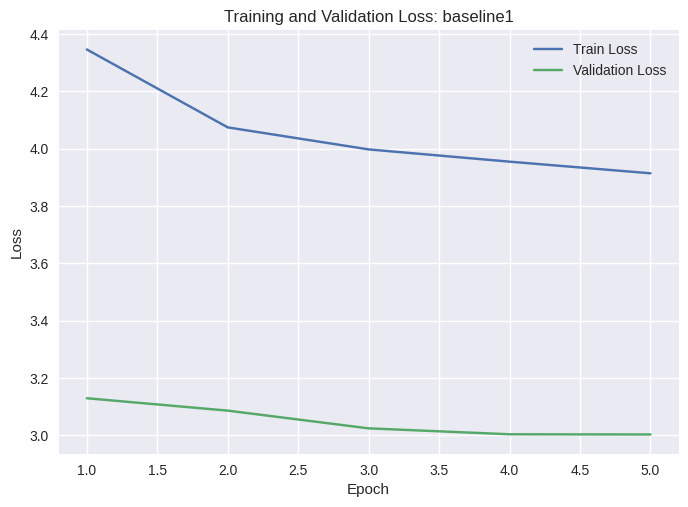


================== Training Summary: baseline1 ==================

[Training Configuration]
- Total Epochs     : 5
- Batch Size       : 30
- Total Iterations : 27150
- Elapsed Time     : 11:58:53

[Best Model (based on BLEU)]
- Epoch            : 4
- Train Loss       : 3.9550
- Val Loss         : 3.0040
- BLEU-4           : 0.2027
- METEOR           : 0.4700
- BERTScore-F1     : 0.7864

[Final Model (last epoch)]
- Epoch            : 5
- Train Loss       : 3.9144
- Val Loss         : 3.0033
- BLEU-4           : 0.2021
- METEOR           : 0.4710
- BERTScore-F1     : 0.7878

Model Parameters    : 10,199,185

Loaded test result file: ./outputs/baseline1_test_results.pt

=== Saved FINAL MODEL (baseline1) test results ===
  Test Loss    : 2.9829
  BLEU-4       : 0.2172
  METEOR       : 0.4924
  BERTScore-F1 : 0.8519
------------------------------------------------------------

================== Evaluating: baseline2 ==================
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): E

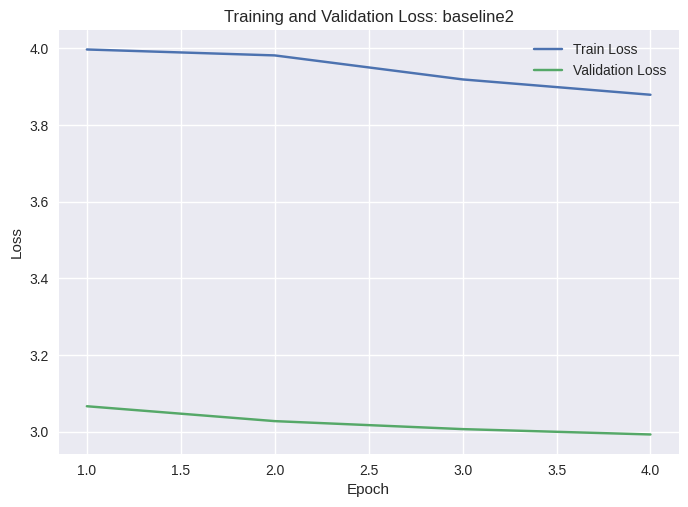


================== Training Summary: baseline2 ==================

[Training Configuration]
- Total Epochs     : 5
- Batch Size       : 30
- Total Iterations : 21720
- Elapsed Time     : 4:07:38

[Best Model (based on BLEU)]
- Epoch            : 4
- Train Loss       : 3.9187
- Val Loss         : 3.0064
- BLEU-4           : 0.2027
- METEOR           : 0.4699
- BERTScore-F1     : 0.7855

[Final Model (last epoch)]
- Epoch            : 5
- Train Loss       : 3.8786
- Val Loss         : 2.9924
- BLEU-4           : 0.2024
- METEOR           : 0.4689
- BERTScore-F1     : 0.7847

Model Parameters    : 14,598,801

Loaded test result file: ./outputs/baseline2_test_results.pt

=== Saved FINAL MODEL (baseline2) test results ===
  Test Loss    : 2.9719
  BLEU-4       : 0.2174
  METEOR       : 0.4936
  BERTScore-F1 : 0.8502
------------------------------------------------------------

================== Evaluating: mild_extension1 ==================
🔎 Using GloVe embeddings for mild_extension1
🔎 L

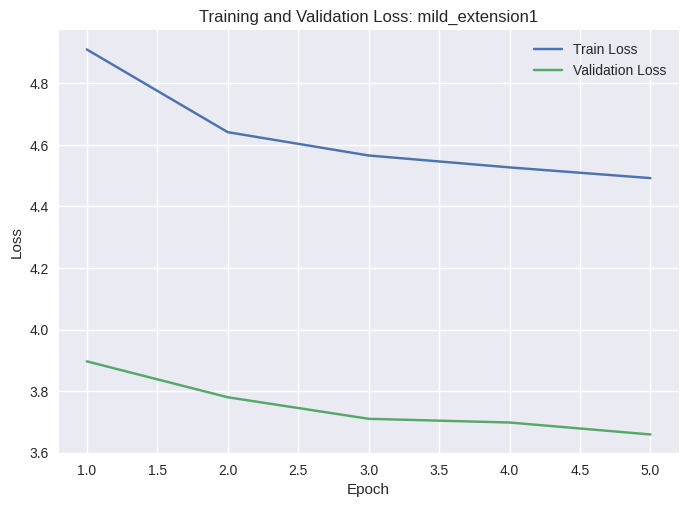


================== Training Summary: mild_extension1 ==================

[Training Configuration]
- Total Epochs     : 5
- Batch Size       : 30
- Total Iterations : 27150
- Elapsed Time     : 5:23:47

[Learning Rate Scheduler]
- LR Step          : 1
- LR Gamma         : 0.7

[Best Model (based on BLEU)]
- Epoch            : 2
- Train Loss       : 4.6417
- Val Loss         : 3.7798
- BLEU-4           : 0.0250
- METEOR           : 0.1248
- BERTScore-F1     : 0.7739

[Final Model (last epoch)]
- Epoch            : 5
- Train Loss       : 4.4923
- Val Loss         : 3.6588
- BLEU-4           : 0.0179
- METEOR           : 0.1167
- BERTScore-F1     : 0.7707

Model Parameters    : 4,651,658

Loaded test result file: ./outputs/mild_extension1_test_results.pt

=== Saved FINAL MODEL (mild_extension1) test results ===
  Test Loss    : 3.6599
  BLEU-4       : 0.0345
  METEOR       : 0.2177
  BERTScore-F1 : 0.8188
------------------------------------------------------------

================== Eva

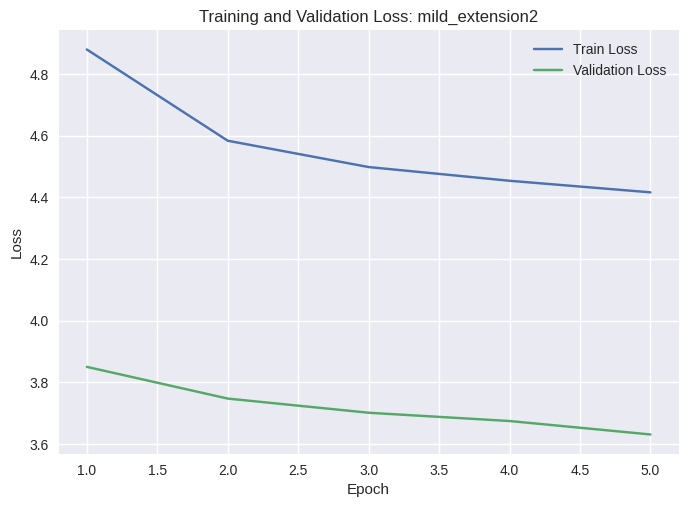


================== Training Summary: mild_extension2 ==================

[Training Configuration]
- Total Epochs     : 5
- Batch Size       : 30
- Total Iterations : 27150
- Elapsed Time     : 6:03:33

[Learning Rate Scheduler]
- LR Step          : 1
- LR Gamma         : 0.7

[Best Model (based on BLEU)]
- Epoch            : 4
- Train Loss       : 4.4639
- Val Loss         : 3.6688
- BLEU-4           : 0.0198
- METEOR           : 0.1175
- BERTScore-F1     : 0.7712

[Final Model (last epoch)]
- Epoch            : 5
- Train Loss       : 4.4164
- Val Loss         : 3.6313
- BLEU-4           : 0.0197
- METEOR           : 0.1191
- BERTScore-F1     : 0.7716

Model Parameters    : 20,055,828

Loaded test result file: ./outputs/mild_extension2_test_results.pt

=== Saved FINAL MODEL (mild_extension2) test results ===
  Test Loss    : 3.6188
  BLEU-4       : 0.0416
  METEOR       : 0.2342
  BERTScore-F1 : 0.8277
------------------------------------------------------------

================== Ev

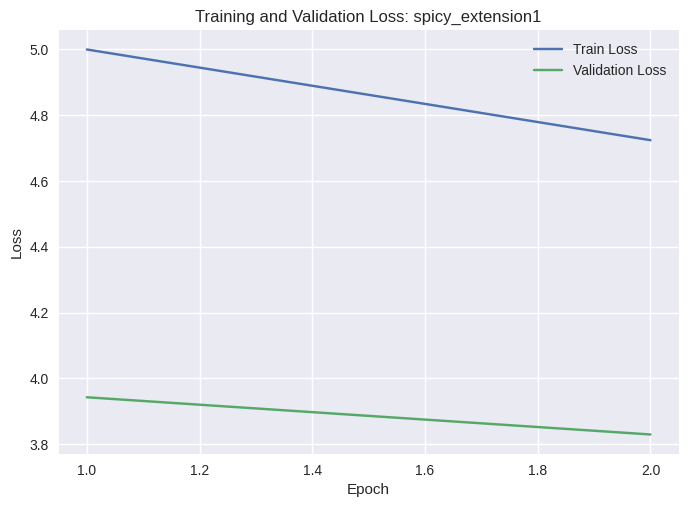


================== Training Summary: spicy_extension1 ==================

[Training Configuration]
- Total Epochs     : 2
- Batch Size       : 30
- Total Iterations : 10860
- Elapsed Time     : 2:08:11

[Learning Rate Scheduler]
- LR Step          : 1
- LR Gamma         : 0.7

[Best Model (based on BLEU)]
- Epoch            : 2
- Train Loss       : 4.7242
- Val Loss         : 3.8293
- BLEU-4           : 0.0209
- METEOR           : 0.1249
- BERTScore-F1     : 0.7811

[Final Model (last epoch)]
- Epoch            : 2
- Train Loss       : 4.7242
- Val Loss         : 3.8293
- BLEU-4           : 0.0209
- METEOR           : 0.1249
- BERTScore-F1     : 0.7811

Model Parameters    : 6,094,262

Loaded test result file: ./outputs/spicy_extension1_test_results.pt

=== Saved FINAL MODEL (spicy_extension1) test results ===
  Test Loss    : 3.8252
  BLEU-4       : 0.0245
  METEOR       : 0.1630
  BERTScore-F1 : 0.8049
------------------------------------------------------------

================== 

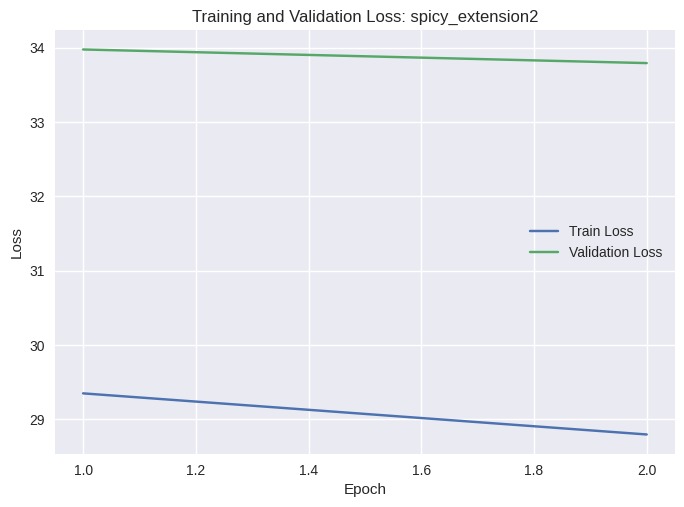


================== Training Summary: spicy_extension2 ==================

[Training Configuration]
- Total Epochs     : 2
- Batch Size       : 4
- Total Iterations : 500
- Elapsed Time     : 1:28:08

[Learning Rate Scheduler]
- LR Step          : 1
- LR Gamma         : 0.7

[Best Model (based on BLEU)]
- Epoch            : 1
- Train Loss       : 29.3512
- Val Loss         : 33.9750
- BLEU-4           : 0.0229
- METEOR           : 0.1859
- BERTScore-F1     : 0.7988

[Final Model (last epoch)]
- Epoch            : 2
- Train Loss       : 28.7984
- Val Loss         : 33.7918
- BLEU-4           : 0.0149
- METEOR           : 0.1088
- BERTScore-F1     : 0.7674

Model Parameters    : 32,093,464

Loaded test result file: ./outputs/spicy_extension2_test_results.pt

=== Saved FINAL MODEL (spicy_extension2) test results ===
  Test Loss    : 22.2512
  BLEU-4       : 0.0209
  METEOR       : 0.1424
  BERTScore-F1 : 0.7860
------------------------------------------------------------


In [185]:
for model_name, cfg in experiment_config.items():
    cfg = cfg.copy()
    cfg["model_type"] = model_name
    print(f"\n================== Evaluating: {model_name} ==================")

    results = summarize_and_test_model(cfg, train_df, dev_df, test_df,plot_loss_epoch_fn)

# Plot per iter

Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.
📥 Loaded BEST model from results/baseline1_best.pt (Epoch 4)
📥 Loaded FINAL model from results/baseline1_5.pt (Epoch 5)
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): AttnDecoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (out): Linear(

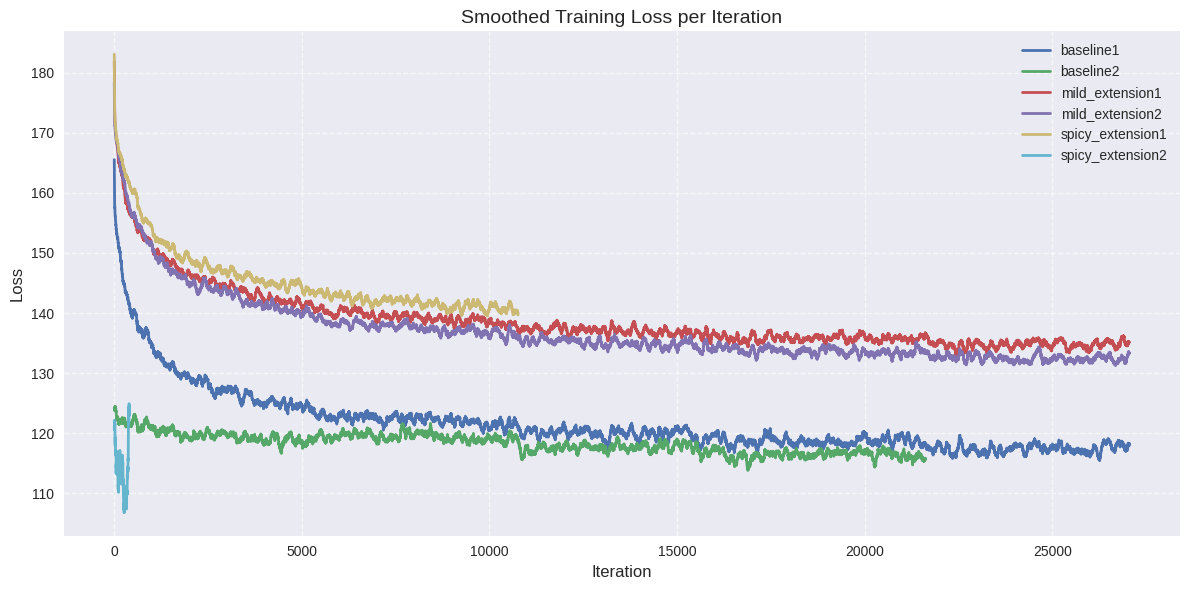

In [ ]:
def smooth(values, window=100):
    return np.convolve(values, np.ones(window)/window, mode='valid')

def plot_all_losses(experiment_config, train_df, window=100):
    plt.style.use("seaborn-v0_8")
    plt.figure(figsize=(12, 6))

    for model_name, cfg in experiment_config.items():
        cfg = cfg.copy()
        cfg["model_type"] = model_name

      
        _, _, loss_history,*_ = load_trained_model(cfg, train_df,dev_df, test_df)
        train_iter_loss = loss_history["train_iter"]

      
        iter_losses = [loss for epoch in train_iter_loss for loss in epoch]
        smoothed = smooth(iter_losses, window=window)

        
        plt.plot(smoothed, label=model_name, linewidth=2)

    plt.title("Smoothed Training Loss per Iteration", fontsize=14)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_all_losses(experiment_config, train_df)


# Generator

In [ ]:
def generate_recipes_for_report(sample_raw, experiment_config, train_df, dev_df, test_df, max_words=30):

    results = {}

    for model_name, orig_cfg in experiment_config.items():
        cfg = orig_cfg.copy()
        cfg["model_type"] = model_name
        cfg["new_model_train"] = False  
        use_checklist = cfg.get('use_checklist', False)
        use_copy = cfg.get('use_copy', False)

        print(f"\n🍳 Generating recipe from model: {model_name}")

       
        best_model, _, _, _, _, _, _, _ = load_trained_model(cfg, train_df, dev_df, test_df)
        best_model.to(DEVICE)
        best_model.eval()

     
        (ing_toks, rec_toks, chk_toks,
         ing_vocab, rec_vocab, chk_vocab,
         tok_ing_train, tok_rec_train, tok_chk, tok_ing_test, tok_rec_test) = \
            load_or_tokenize_data(train_df, cfg)

      
        if isinstance(sample_raw, str):
            ingredients = [i.strip() for i in sample_raw.split(',')]
        else:
            ingredients = sample_raw

        ingredient_str = str(ingredients)
        tokenized = tok_rec_test(ingredient_str)
        input_ids = torch.tensor(
            [ing_vocab[t] for t in tokenized],
            dtype=torch.long
        ).unsqueeze(0).to(DEVICE)

        # 4) 생성 (그리디 or beam search)
        with torch.no_grad():
            pred_ids = best_model.generate(
                src=input_ids,
                ing_texts=ingredients if use_checklist else None,
                encoder_input_ids=input_ids if use_copy else None,
                max_len=max_words,
                beam_size=5
            )

      
        itos = rec_vocab.get_itos()
        tokens = [itos[i] for i in pred_ids[0].tolist()]
        truncated = tokens[:max_words]
        results[model_name] = ' '.join(truncated)

    return results


In [188]:
sample = "sugar, lemon juice, water, orange juice, strawberries, icecream"
sample2= "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"


recipe_outputs = generate_recipes_for_report(sample2, experiment_config, train_df, dev_df, test_df)

for model, text in recipe_outputs.items():
    print(f"\n=== {model} ===\n{text}")


🍳 Generating recipe from model: baseline1
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.

🍳 Generating recipe from model: baseline2
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): AttnDecoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (out): Linear(in_features=1024, out_features=859

# Fill the excel

In [ ]:


def generate_recipes_to_excel(
    excel_path: str,
    output_path: str,
    experiment_config: dict,
    train_df,
    dev_df,
    test_df,
    max_words: int = 30
):
    

    df = pd.read_excel(excel_path)
    df['Ingredients'] = df['Ingredients'].apply(ast.literal_eval)


    for model_name, base_cfg in experiment_config.items():
        print(f"\n Processing Model: {model_name}")
        cfg = base_cfg.copy()
        cfg["model_type"] = model_name
        cfg["new_model_train"] = False

     
        _, final_model, _, _, _, _, _, _ = load_trained_model(cfg, train_df, dev_df, test_df)
        model = final_model.to(DEVICE)
        model.eval()

        tokens = load_or_tokenize_data(train_df, cfg)
        ing_vocab = tokens[3]
        rec_vocab = tokens[4]
        tok_rec_test = tokens[-1]
        itos = rec_vocab.get_itos()

       
        result_col = f"Recipe - {model_name}"
        df[result_col] = ""


        for i, ingredients in tqdm(enumerate(df['Ingredients']), total=len(df)):
            ingredient_str = str(ingredients)
            tokenized = tok_rec_test(ingredient_str)
            input_ids = torch.tensor(
                [ing_vocab[t] for t in tokenized],
                dtype=torch.long
            ).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                pred_ids = model.generate(
                    src=input_ids,
                    ing_texts=ingredients if cfg.get("use_checklist", False) else None,
                    encoder_input_ids=input_ids if cfg.get("use_copy", False) else None,
                    max_len=max_words,
                    beam_size=5
                )

            tokens_out = [itos[i] for i in pred_ids[0].tolist()]
            recipe = ' '.join(tokens_out[:max_words])
            df.at[i, result_col] = recipe

        print(f"{model_name} Complete!")


    df.to_excel(output_path, index=False)
    print(f"\n Complete Saving Excel! → {output_path}")



In [191]:
generate_recipes_to_excel(
    excel_path="/home/psarda/repos/jkim0094-CookingRecipeGenerato/a.xlsx",
    output_path="/home/psarda/repos/jkim0094-CookingRecipeGenerato/a_filled.xlsx",
    experiment_config=experiment_config,
    train_df=train_df,
    dev_df=dev_df,
    test_df=test_df,
    max_words=30
)




 Processing Model: baseline1
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.
📥 Loaded BEST model from results/baseline1_best.pt (Epoch 4)
📥 Loaded FINAL model from results/baseline1_5.pt (Epoch 5)


100%|██████████| 1081/1081 [01:08<00:00, 15.84it/s]


baseline1 Complete!

 Processing Model: baseline2
Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(4788, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
  )
  (decoder): AttnDecoder_GRU(
    (embedding): Embedding(8593, 256, padding_idx=0)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (out): Linear(in_features=1024, out_features=8593, bias=True)
  )
  (recipe_vocab): Vocab()
)
✅  Already trained through epoch 5. No further training needed.
📥 Loaded BEST model from results/baseline2_best.pt (Epoch 4)
📥 Loaded FINAL model from results/baseline2_5.pt (Epoch 5)


100%|██████████| 1081/1081 [01:22<00:00, 13.05it/s]


baseline2 Complete!

 Processing Model: mild_extension1
🔎 Using GloVe embeddings for mild_extension1
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(9059, 100, padding_idx=0)
    (embedding_adapter): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(100, 200, batch_first=True)
    (token_attention): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): AttnDecoder_GRU_extension(
    (embedding): Embedding(10714, 100, padding_idx=0)
    (embedding_adapter): Linear(in_features=100, out_features=100, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(100, 200, batch_first=

100%|██████████| 1081/1081 [01:36<00:00, 11.16it/s]


mild_extension1 Complete!

 Processing Model: mild_extension2
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(13385, 256, padding_idx=0)
    (embedding_adapter): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (token_attention): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): AttnDecoder_GRU_extension(
    (embedding): Embedding(13385, 256, padding_idx=0)
    (embedding_adapter): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (context_attn): Linear(in_features=512, out_features=512, bias=True)
    (output_proj): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): GELU

100%|██████████| 1081/1081 [01:41<00:00, 10.60it/s]


mild_extension2 Complete!

 Processing Model: spicy_extension1
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(9059, 128, padding_idx=0)
    (embedding_adapter): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(128, 256, batch_first=True)
    (token_attention): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): AttnDecoder_GRU_extension(
    (embedding): Embedding(10714, 128, padding_idx=0)
    (embedding_adapter): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(128, 256, batch_first=True)
    (context_attn): Linear(in_features=256, out_features=256, bias=True)
    (output_proj): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): LayerNorm((256,), eps=1

100%|██████████| 1081/1081 [01:36<00:00, 11.25it/s]


spicy_extension1 Complete!

 Processing Model: spicy_extension2
Seq2Seq(
  (encoder): Encoder_GRU_extension(
    (embedding): Embedding(13385, 256, padding_idx=0)
    (embedding_adapter): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 512, batch_first=True)
    (token_attention): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): DecoderWithCopyChecklist(
    (checklist_vocab): Vocab()
    (copy_vocab): Vocab()
    (embedding): Embedding(13385, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attn_proj): Linear(in_features=512, out_features=512, bias=True)
    (skip_proj): Linear(in_features=256, out_features=1024, bias=True)
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (context_out): Linear(in_features=1024, out

100%|██████████| 1081/1081 [02:23<00:00,  7.54it/s]


spicy_extension2 Complete!

 Complete Saving Excel! → /home/psarda/repos/jkim0094-CookingRecipeGenerato/a_filled.xlsx


# Check vocab, Table for results

In [ ]:
for model_name, orig_cfg in experiment_config.items():

    cfg = orig_cfg.copy()
    cfg["model_type"] = model_name


    (_,
     _,
     _,
     ingredient_vocab,
     recipe_vocab,
     checklist_vocab,
     _,
     _,
     _,
     _,
     _) = load_or_tokenize_data(train_df, cfg)


    ing_stoi = ingredient_vocab.get_stoi()
    rec_stoi = recipe_vocab.get_stoi()
    rec_itos = recipe_vocab.get_itos()

    print(f"\n=== Model: {model_name} ===")
    print("▶ ingredient vocab size:", len(ing_stoi))
    print("  sample tokens:", list(ing_stoi.keys())[:20])
    print("▶ recipe vocab size    :", len(rec_stoi))
    print("  first 20 tokens by index:", rec_itos[:20])
    # special token 존재 여부
    for sp in ['<pad>', '<unk>', '<sos>', '<eos>']:
        print(f"  {sp:5s} in recipe_vocab?", sp in rec_stoi)
    if checklist_vocab is not None:
        chk_stoi = checklist_vocab.get_stoi()
        print("▶ checklist vocab size :", len(chk_stoi))
    print("-" * 40)



=== Model: baseline1 ===
▶ ingredient vocab size: 4788
  sample tokens: ['zason', 'z.', 'yoplait', 'yellowfin', 'ye', 'worcester', 'woman', 'wok', 'wingette', 'wienie', 'whisky', 'weiss', 'weinberg', 'weenie', 'weaken', 'waxy', 'walker', 'walk', 'vietnamese', 'verbena']
▶ recipe vocab size    : 8593
  first 20 tokens by index: ['<pad>', '<sos>', '<eos>', '<unk>', 'and', 'in', 'add', 'to', 'until', 'with', 'a', 'the', 'mix', 'of', 'minutes', 'into', 'for', 'cook', 'on', 'stir']
  <pad> in recipe_vocab? True
  <unk> in recipe_vocab? True
  <sos> in recipe_vocab? True
  <eos> in recipe_vocab? True
----------------------------------------

=== Model: baseline2 ===
▶ ingredient vocab size: 4788
  sample tokens: ['zason', 'z.', 'yoplait', 'yellowfin', 'ye', 'worcester', 'woman', 'wok', 'wingette', 'wienie', 'whisky', 'weiss', 'weinberg', 'weenie', 'weaken', 'waxy', 'walker', 'walk', 'vietnamese', 'verbena']
▶ recipe vocab size    : 8593
  first 20 tokens by index: ['<pad>', '<sos>', '<eos>'

In [ ]:
def compare_metric_across_models(model_types, metric_key="bleu", results_dir="results"):

    metric_table = {}

    for model_type in model_types:
        pattern = os.path.join(results_dir, f"{model_type}_*.pt")
        ckpt_paths = sorted(glob.glob(pattern))

        metric_per_epoch = {}

        for path in ckpt_paths:
            fname = os.path.basename(path)
            match = re.match(rf"{re.escape(model_type)}_(\d+)\.pt", fname)
            if match:
                epoch = int(match.group(1))
                ckpt = torch.load(path, map_location="cpu")
                value = ckpt.get(metric_key, None)
                if value is not None:
                    metric_per_epoch[epoch] = value


        if metric_per_epoch:
            sorted_dict = dict(sorted(metric_per_epoch.items()))
            metric_table[model_type] = sorted_dict


    all_epochs = sorted(set(epoch for values in metric_table.values() for epoch in values))


    df = pd.DataFrame({model: [values.get(ep, None) for ep in all_epochs]
                       for model, values in metric_table.items()},
                      index=all_epochs)
    df.index.name = "Epoch"

    print(f"\n📊 Comparison: {metric_key.upper()} across models")
    display(df.round(4))  
    return df


In [ ]:
compare_metric_across_models(
    model_types=["baseline1", "baseline2","mild_extension1","mild_extension2","spicy_extension1","spicy_extension2"],
    metric_key="train_loss"
)

compare_metric_across_models(
    model_types=["baseline1", "baseline2","mild_extension1","mild_extension2","spicy_extension1","spicy_extension2"],
    metric_key="val_loss"
)

compare_metric_across_models(
    model_types=["baseline1", "baseline2","mild_extension1","mild_extension2","spicy_extension1","spicy_extension2"],
    metric_key="bleu"
)
compare_metric_across_models(
    model_types=["baseline1", "baseline2","mild_extension1","mild_extension2","spicy_extension1","spicy_extension2"],
    metric_key="meteor"
)
compare_metric_across_models(
    model_types=["baseline1", "baseline2","mild_extension1","mild_extension2","spicy_extension1","spicy_extension2"],
    metric_key="bert_f1"
)



📊 Comparison: TRAIN_LOSS across models


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,4.3464,4.2824,4.9105,4.8753,5.0000,29.3512
2,4.0746,3.9968,4.6417,4.5878,4.7242,28.7984
3,3.9978,3.9813,4.5658,4.5092,NaN,NaN
4,3.9550,3.9187,4.5271,4.4639,NaN,NaN
5,3.9144,3.8786,4.4923,4.4164,NaN,NaN



📊 Comparison: VAL_LOSS across models


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,3.1297,3.1174,3.8965,3.8697,3.9425,33.9750
2,3.0865,3.0661,3.7798,3.7471,3.8293,33.7918
3,3.0246,3.0273,3.7098,3.7051,NaN,NaN
4,3.0040,3.0064,3.6977,3.6688,NaN,NaN
5,3.0033,2.9924,3.6588,3.6313,NaN,NaN



📊 Comparison: BLEU across models


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,0.2004,0.2012,0.0178,0.0173,0.0192,0.0229
2,0.2020,0.2013,0.0250,0.0187,0.0209,0.0149
3,0.2014,0.2009,0.0195,0.0192,NaN,NaN
4,0.2027,0.2027,0.0209,0.0198,NaN,NaN
5,0.2021,0.2024,0.0179,0.0197,NaN,NaN



📊 Comparison: METEOR across models


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,0.4683,0.4677,0.1109,0.1186,0.1191,0.1859
2,0.4685,0.4677,0.1248,0.1129,0.1249,0.1088
3,0.4694,0.4656,0.1209,0.1160,NaN,NaN
4,0.4700,0.4699,0.1238,0.1175,NaN,NaN
5,0.4710,0.4689,0.1167,0.1191,NaN,NaN



📊 Comparison: BERT_F1 across models


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,0.7850,0.7858,0.7680,0.7715,0.7777,0.7988
2,0.7867,0.7855,0.7739,0.7677,0.7811,0.7674
3,0.7855,0.7831,0.7724,0.7705,NaN,NaN
4,0.7864,0.7855,0.7740,0.7712,NaN,NaN
5,0.7878,0.7847,0.7707,0.7716,NaN,NaN


,baseline1,baseline2,mild_extension1,mild_extension2,spicy_extension1,spicy_extension2
Epoch,,,,,,
1,0.784993,0.785760,0.768001,0.771500,0.777651,0.798760
2,0.786725,0.785484,0.773928,0.767745,0.781081,0.767368
3,0.785521,0.783085,0.772375,0.770485,NaN,NaN
4,0.786447,0.785481,0.774035,0.771234,NaN,NaN
5,0.787837,0.784678,0.770687,0.771554,NaN,NaN


In [ ]:
import os
import torch
import pandas as pd

def load_test_results_in_order(model_names, output_dir="./outputs"):
   
    results = []

    for model_name in model_names:
        result_path = os.path.join(output_dir, f"{model_name}_test_results.pt")

        if not os.path.exists(result_path):
            print(f"No file: {result_path}")
            continue

        data = torch.load(result_path)
        final_result = data.get("results", {}).get("final", None)

        if final_result:
            results.append({
                "Model": model_name,
                "Test Loss": final_result["test_loss"],
                "BLEU": final_result["BLEU"],
                "METEOR": final_result["METEOR"],
                "BERTScore-F1": final_result["BERTScore-F1"]
            })
        else:
            print(f"No 'final' result: {result_path}")

    df = pd.DataFrame(results)
    print("\n📊 Model Test Results:")
    print(df)
    return df


In [ ]:
model_list = ["baseline1","baseline2","mild_extension1", "mild_extension2","spicy_extension1","spicy_extension2"]
df = load_test_results_in_order(model_list)



📊 모델별 테스트 결과:
              Model  Test Loss      BLEU    METEOR  BERTScore-F1
0         baseline1   2.982851  0.217249  0.492366      0.851867
1         baseline2   2.971933  0.217418  0.493575      0.850229
2   mild_extension1   3.659901  0.034519  0.217720      0.818822
3   mild_extension2   3.618823  0.041644  0.234205      0.827726
4  spicy_extension1   3.825158  0.024480  0.162957      0.804865
5  spicy_extension2  22.251177  0.020873  0.142441      0.786042
